# 📊 Exploratory Data Analysis (EDA) - Burnout Prediction

## Notebook Objective

This notebook performs exploratory data analysis (EDA) on the "Work-Life Balance Synthetic Daily Wellness" dataset.

### What we do:
1. **Load data**: daily_logs, weekly_summaries, interventions
2. **Target Feature Engineering**: Create `burnout_score` (continuous) and `burnout_level` (3 classes)
3. **Distribution analysis**: Histograms of burnout score
4. **Correlations**: Heatmap of correlations between features and burnout
5. **Missing values**: Data completeness analysis

### Burnout Score Formula

Burnout is calculated as a standardized z-score combination of:
- **Positive** (increase burnout): stress, anxiety, depression, sleep debt
- **Negative** (reduce burnout): job satisfaction

```
burnout_score = (z_stress + z_anxiety + z_depression + z_sleep_debt - z_job_satisfaction) / 5
```

### Dataset
- **1000 synthetic users** × 365 days of tracking
- **Features**: sleep, work, exercise, mood and stress metrics

In [ ]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================
# pandas/numpy: data manipulation
# matplotlib/seaborn: visualization
# StandardScaler: z-score standardization for burnout score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Display configuration
pd.set_option('display.max_columns', None)  # Show all columns
sns.set_theme(style='whitegrid', context='talk')  # Clean style for charts

In [ ]:
# =============================================================================
# LOAD DATASET
# =============================================================================
# The Kaggle dataset contains 4 main files:
# - daily_logs: daily metrics per user (sleep, work, mood, etc.)
# - daily_all: expanded version with more details
# - interventions: wellness interventions for each user
# - weekly_summaries: weekly aggregations with psychometric scales

RAW_DIR = '../data/raw/'

# Load all datasets with automatic date parsing
daily_logs = pd.read_csv(f'{RAW_DIR}daily_logs.csv', parse_dates=['date'])
daily_all = pd.read_csv(f'{RAW_DIR}daily_all.csv', parse_dates=['date', 'week_start'])
interventions = pd.read_csv(f'{RAW_DIR}interventions.csv', parse_dates=['start_date', 'end_date'])
weekly = pd.read_csv(f'{RAW_DIR}weekly_summaries.csv', parse_dates=['week_start'])

# Check dimensions: we expect ~365k rows for daily (1000 users × 365 days)
print('daily_logs', daily_logs.shape)
print('daily_all', daily_all.shape)
print('interventions', interventions.shape)
print('weekly', weekly.shape)

daily_logs (731000, 26)
daily_all (731000, 53)
interventions (332, 6)
weekly (105000, 10)


In [ ]:
# =============================================================================
# DATA PREVIEW
# =============================================================================
# Display first rows to understand the data structure

display(daily_logs.head())    # Daily metrics: sleep_hours, work_hours, stress_level, etc.
display(weekly.head())        # Weekly aggregations + psychometric scales (PSS, anxiety, depression)
display(interventions.head()) # Wellness interventions (e.g., mindfulness programs)

,user_id,date,workday,sleep_hours,sleep_quality,work_hours,meetings_count,tasks_completed,emails_received,commute_minutes,exercise_minutes,steps_count,caffeine_mg,alcohol_units,screen_time_hours,social_interactions,outdoor_time_minutes,diet_quality,calories_intake,stress_level,mood_score,energy_level,focus_score,work_pressure,weather_mood_impact,weight_kg
0,1,2024-01-01,True,7.14,6,6.99,3,6,51,16,33,8502,83,0.00,8.41,2,7,4,2125,4,3,3,7,low,-0.5,73.25
1,1,2024-01-02,True,7.61,5,8.42,6,0,50,36,57,10977,121,0.69,8.21,1,23,6,2465,6,5,6,2,low,-0.5,73.23
2,1,2024-01-03,True,8.00,7,7.21,4,10,57,35,29,6344,140,0.22,5.70,3,22,3,2235,3,6,7,7,low,-0.5,73.20
3,1,2024-01-04,True,7.19,5,7.85,4,0,38,33,51,10352,191,0.03,7.13,3,34,5,2433,5,4,6,6,low,-0.5,73.18
4,1,2024-01-05,True,7.95,8,7.17,1,7,38,30,51,9153,242,0.35,5.29,2,24,7,1852,3,8,5,5,low,-0.5,73.09


,user_id,week_start,job_satisfaction,perceived_stress_scale,anxiety_score,depression_score,sleep_debt_hours,avg_weight_kg,workouts_count,cheat_meals_count
0,1,2024-01-01,7,17,5,13,0.1,73.132857,10,1
1,1,2024-01-08,7,18,5,12,2.9,72.850000,8,1
2,1,2024-01-15,7,18,5,12,2.4,72.708571,8,1
3,1,2024-01-22,7,17,5,9,3.4,72.434286,6,0
4,1,2024-01-29,7,15,4,13,6.0,72.242857,7,1


,user_id,start_date,end_date,type,intensity,notes
0,3,2024-08-29,2024-09-02,sick_leave,high,NaN
1,3,2025-05-27,2025-06-02,meditation,high,NaN
2,9,2024-12-03,2024-12-08,therapy,high,NaN
3,9,2024-08-29,2024-09-30,workload_cap,low,NaN
4,10,2024-10-08,2024-10-20,meditation,medium,NaN


In [ ]:
# =============================================================================
# CREATE BURNOUT SCORE (TARGET VARIABLE)
# =============================================================================
# Burnout is not directly measurable, so we create a proxy score
# based on validated psychometric indicators from weekly_summaries dataset.
#
# METHODOLOGY:
# 1. Standardize (z-score) each indicator to make them comparable
# 2. Sum contributions: stress, anxiety, depression, sleep debt = POSITIVE
#                       job satisfaction = NEGATIVE
# 3. Divide by 5 to get a normalized score

# Columns that contribute to burnout
score_cols = [
    'perceived_stress_scale',  # PSS: 0-40 scale, measures perceived stress
    'anxiety_score',           # GAD-7: generalized anxiety scale
    'depression_score',        # PHQ-9: depression scale
    'sleep_debt_hours',        # Hours of sleep lost relative to need
    'job_satisfaction',        # Job satisfaction (protective factor)
]

# Z-score standardization: (x - mean) / std
# After this transformation, each column has mean=0 and std=1
scaler = StandardScaler()
weekly_z = scaler.fit_transform(weekly[score_cols])
weekly_z = pd.DataFrame(weekly_z, columns=score_cols, index=weekly.index)

# Calculate composite burnout score
# NOTE: job_satisfaction is SUBTRACTED because it reduces burnout
weekly['burnout_score'] = (
    weekly_z['perceived_stress_scale']
    + weekly_z['anxiety_score']
    + weekly_z['depression_score']
    + weekly_z['sleep_debt_hours']
    - weekly_z['job_satisfaction']
) / 5.0

# =============================================================================
# DISCRETIZATION INTO 3 CLASSES (for classification)
# =============================================================================
# We use 33rd and 66th percentiles to divide into Low/Medium/High burnout
# This ensures balanced classes (~33% each)

low_thr = weekly['burnout_score'].quantile(0.33)   # Low/medium threshold
high_thr = weekly['burnout_score'].quantile(0.66)  # Medium/high threshold

def classify_burnout(score: float) -> int:
    """Classify burnout score into 3 levels."""
    if score < low_thr:
        return 0  # Low burnout
    if score < high_thr:
        return 1  # Medium burnout
    return 2      # High burnout

weekly['burnout_level'] = weekly['burnout_score'].apply(classify_burnout)

# Check class distribution
weekly[['burnout_score', 'burnout_level']].head()

,burnout_score,burnout_level
0,-0.276946,1
1,-0.158595,1
2,-0.184714,1
3,-0.538821,0
4,-0.359059,0


In [ ]:
# =============================================================================
# MERGE: PROPAGATE BURNOUT TO DAILY DATA
# =============================================================================
# Each daily row inherits the burnout_level of its week.
# This allows us to use daily features to predict burnout.

# Extract ISO week number for the join
daily_logs['week'] = daily_logs['date'].dt.isocalendar().week.astype(int)
weekly['week'] = weekly['week_start'].dt.isocalendar().week.astype(int)

# Left join: keep all daily records, add burnout if available
merged = daily_logs.merge(
    weekly[['user_id', 'week', 'burnout_score', 'burnout_level']],
    on=['user_id', 'week'],
    how='left'
)

# Note: some rows might have NaN if the week doesn't match
merged.head()

,user_id,date,workday,sleep_hours,sleep_quality,work_hours,meetings_count,tasks_completed,emails_received,commute_minutes,exercise_minutes,steps_count,caffeine_mg,alcohol_units,screen_time_hours,social_interactions,outdoor_time_minutes,diet_quality,calories_intake,stress_level,mood_score,energy_level,focus_score,work_pressure,weather_mood_impact,weight_kg,week,burnout_score,burnout_level
0,1,2024-01-01,True,7.14,6,6.99,3,6,51,16,33,8502,83,0.00,8.41,2,7,4,2125,4,3,3,7,low,-0.5,73.25,1,-0.276946,1
1,1,2024-01-01,True,7.14,6,6.99,3,6,51,16,33,8502,83,0.00,8.41,2,7,4,2125,4,3,3,7,low,-0.5,73.25,1,-0.325122,1
2,1,2024-01-01,True,7.14,6,6.99,3,6,51,16,33,8502,83,0.00,8.41,2,7,4,2125,4,3,3,7,low,-0.5,73.25,1,1.223867,2
3,1,2024-01-02,True,7.61,5,8.42,6,0,50,36,57,10977,121,0.69,8.21,1,23,6,2465,6,5,6,2,low,-0.5,73.23,1,-0.276946,1
4,1,2024-01-02,True,7.61,5,8.42,6,0,50,36,57,10977,121,0.69,8.21,1,23,6,2465,6,5,6,2,low,-0.5,73.23,1,-0.325122,1


/tmp/ipykernel_19449/652649766.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='burnout_level', data=weekly, palette='Set2', ax=ax[1])


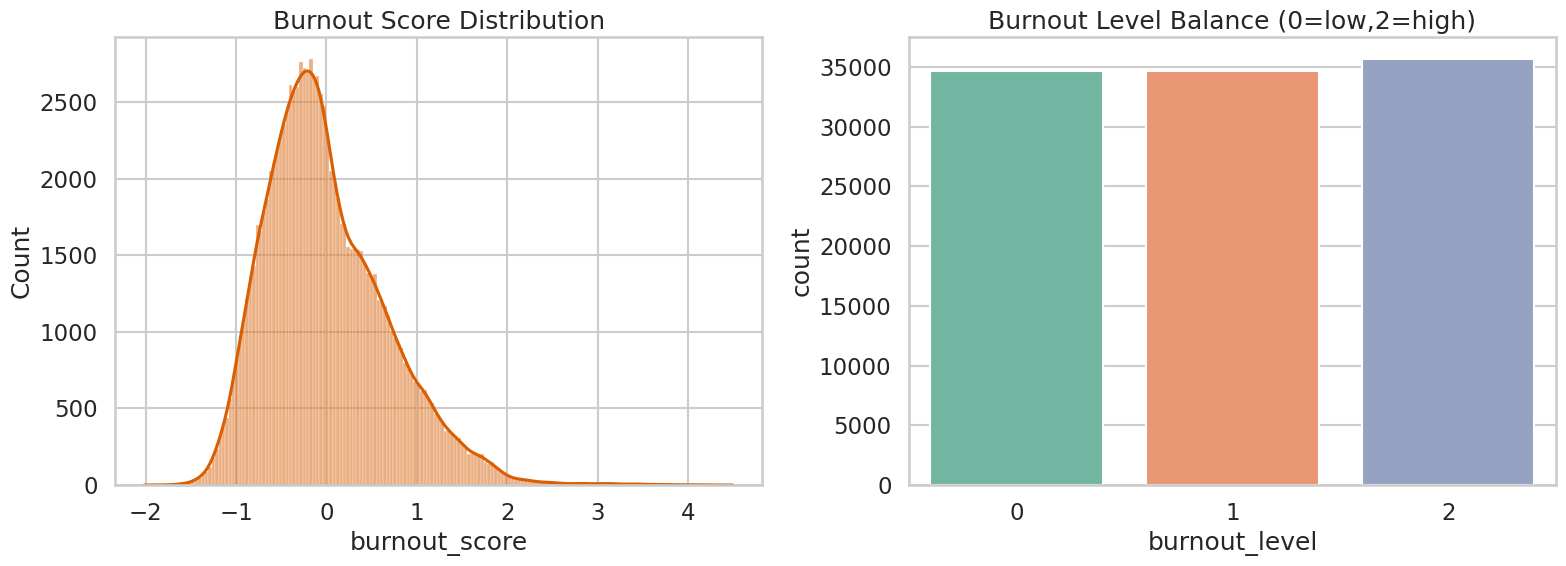

In [ ]:
# =============================================================================
# VISUALIZATION: BURNOUT DISTRIBUTION
# =============================================================================
# Verify that burnout_score follows a reasonable distribution
# and that classes are balanced (important for training)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Left: Histogram of burnout score (continuous)
# A normal distribution suggests our composite score is robust
sns.histplot(weekly['burnout_score'], kde=True, ax=ax[0], color='#d95f02')
ax[0].set_title('Burnout Score Distribution')
ax[0].set_xlabel('Burnout Score (z-score composite)')

# Right: Barplot of classes
# We should see ~33% per class thanks to percentiles
sns.countplot(x='burnout_level', data=weekly, palette='Set2', ax=ax[1])
ax[1].set_title('Burnout Level Balance (0=Low, 1=Medium, 2=High)')
ax[1].set_xlabel('Burnout Level')

plt.tight_layout()

Text(0.5, 1.0, 'Correlation with Burnout Score')

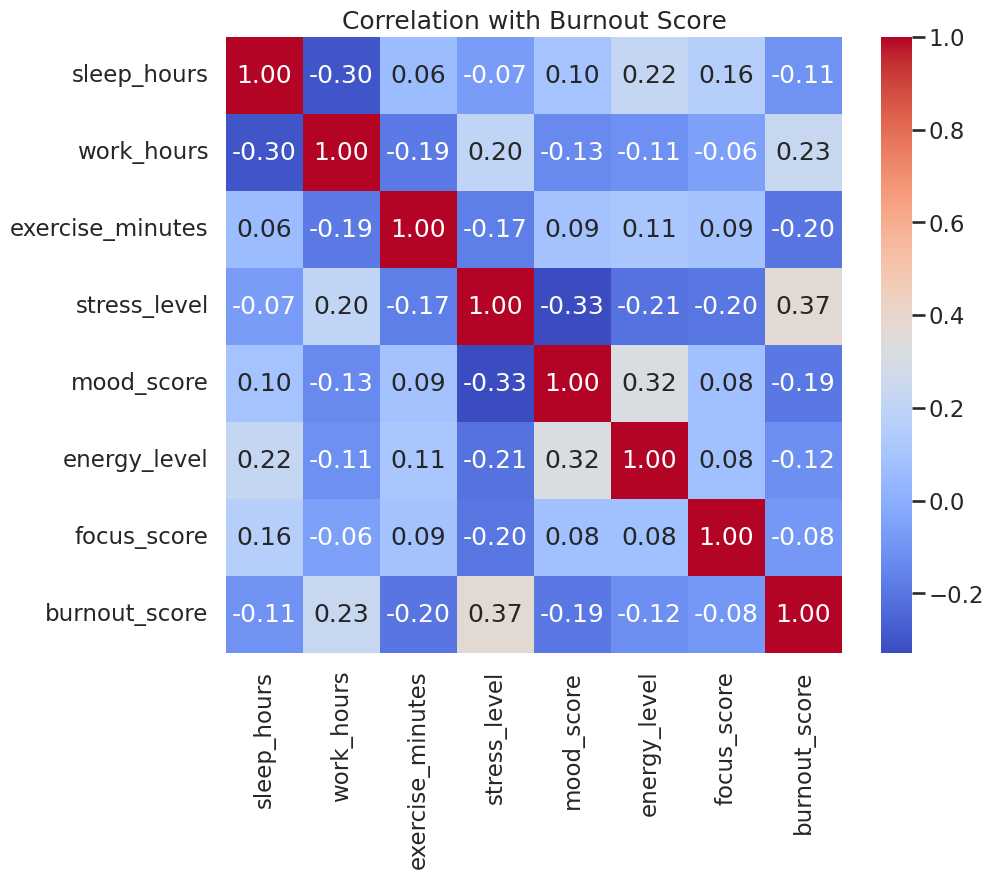

In [ ]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
# Which daily features correlate with burnout?
# This guides feature selection and model interpretation.

# Key features to analyze
eda_cols = [
    'sleep_hours',      # Sleep: expect NEGATIVE correlation
    'work_hours',       # Work: POSITIVE correlation (more work = more burnout)
    'exercise_minutes', # Exercise: NEGATIVE correlation (protective)
    'stress_level',     # Stress: POSITIVE correlation (strong!)
    'mood_score',       # Mood: NEGATIVE correlation
    'energy_level',     # Energy: NEGATIVE correlation
    'focus_score',      # Focus: NEGATIVE correlation
    'work_pressure'     # Pressure: POSITIVE correlation (categorical but ordinal)
]

# Correlation matrix
corr = merged[eda_cols + ['burnout_score']].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, center=0)
plt.title('Correlation with Burnout Score\n(Red = positive, Blue = negative)')

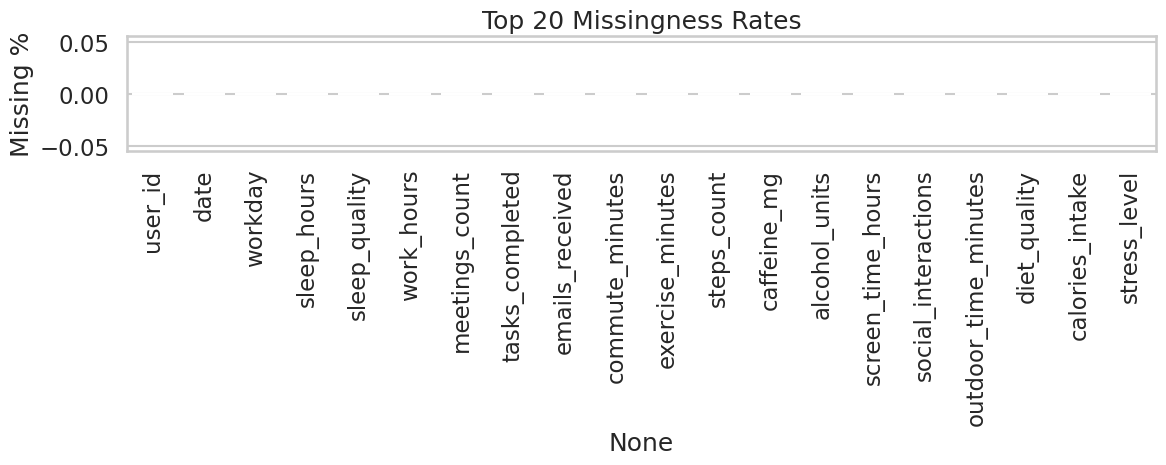

In [ ]:
# =============================================================================
# MISSING VALUES ANALYSIS
# =============================================================================
# Before preprocessing, check data quality.
# Missing values may require imputation or exclusion.

missing_pct = merged.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=missing_pct.index[:20], y=missing_pct.values[:20], color='#1b9e77')
plt.xticks(rotation=90)
plt.ylabel('Missing Rate (%)')
plt.title('Top 20 Features by Missingness Rate')
plt.tight_layout()

# NOTE: If a feature has >50% missing, it might be better to exclude it
# In our synthetic dataset, missing values are generally <5%

## 📌 Key EDA Takeaways

### Target Distribution
- Burnout score follows an **approximately normal distribution**, validating our z-score approach
- The 3 classes are **balanced** (~33% each) thanks to percentile-based binning

### Important Correlations
- **Stress level** has the **strongest correlation** with burnout (positive)
- **Mood score** and **energy level** are **inversely correlated** (protective factors)
- **Sleep hours** shows negative correlation (sleep reduces burnout)
- **Work hours** and **work pressure** increase burnout risk

### Data Quality
- Limited missing values (<5% for most features)
- High-quality synthetic dataset, ready for preprocessing

### Next Steps
The `merged` dataframe contains all data needed for:
1. **Preprocessing** (`scripts/preprocess.py`): weekly aggregation, scaling
2. **Modeling**: baseline models (Random Forest) and deep learning (MLP, LSTM, Transformer)